<p align="center">
    <img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="400"/>
</p>

---

<p align="center">
<img src="https://pytorch.org/assets/images/pytorch-logo.png" alt="drawing" width="100"/>
</p>



<h1 style="text-align: center;"> Introduction to Pytorch for Deep Learning
  – Exercises</h1>


#### **Afternoon contents/agenda**

1. Understanding the basics:
- [But what is a convolution?](https://www.youtube.com/watch?v=KuXjwB4LzSA&ab_channel=3Blue1Brown)

- [But what is a neural network?](https://www.youtube.com/watch?v=aircAruvnKk&t=1s&ab_channel=3Blue1Brown)

- [What is backpropagation really doing?](https://www.youtube.com/watch?v=Ilg3gGewQ5U&t=2s&ab_channel=3Blue1Brown)

2. In this exercise we will work with a chest x-ray dataset from [MedMnist](https://github.com/MedMNIST/MedMNIST) to tackle a reconstruction problem. Often, bio-engineering datasets have sparse or missing information which are difficult to to avoid due to poor design unexpected failures or restricitions in acquisition times. Interpolation is a common method to pre-process the data to simulate missing data, but fails when the amount of information is large. Here we will use a neural network to predict missing values by learning the distribution of the dataset as opposed to localised operations.

### 2.0 Some imports and utils

In [1]:
# try:
#   from google.colab import drive
#   drive.mount('/content/drive')
# except:
#   pass

In [2]:
from torchvision.transforms import Compose, ToTensor, GaussianBlur, Resize, Grayscale, Lambda


In [3]:
# !pip install torchsummary progressbar2 livelossplot monai -q

import torch
import torch.nn as nn
import numpy as np
import random
from torch.utils.data import Dataset
from PIL import Image
# from torchsummary import summary
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from torchvision import transforms

# def set_seed(seed):
#     """
#     Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
#     """
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)

#     torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
#     torch.backends.cudnn.enabled   = True

#     return True


# def set_device(device="cpu", idx=0):
#     if device != "cpu":
#         if torch.cuda.device_count() > idx and torch.cuda.is_available():
#             print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
#             device="cuda:{}".format(idx)
#         elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
#             print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
#             device="cuda:0"
#         else:
#             device="cpu"
#             print("No GPU available! Running on CPU")
#     return device

# device = set_device("cuda")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
print(torch.cuda.is_available())

True


### 2.1  Download and inspect the data using the commands below


In [5]:
# !wget https://zenodo.org/record/6496656/files/chestmnist.npz

In [6]:
ex_data = np.load("./chestmnist.npz")
print(ex_data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


### 2.3 Create a custom dataset

* Create your own ``Dataset`` derived class that takes as initialisation arguments:
  - ``data_path``, the path to the data
  - a probability for a random mask ``p``,
  - a ``transform`` to be applied to the data,
  - and a ``split`` argument to dictate what part of the data to load (train, validation, test)

* Load the data into an argument ``self.data`` inside the initialisation

* Create a method for your class ``_get_mask``, that generates a binary mask of the size of the sample to randomly erase some data points based on the probability ``p``

* Customise the  ``__getitem__`` class so that it loads a sample from ``self.data`` and returns a masked version of the sample, and the original sample (the former will be input to our network and the later the target)

* Don't forget to set the built-in method ``__len__`` to the correct size

* Instantiate the class for a training set and a validation set. Plot one input and output for each of these sets

In [7]:
print(ex_data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [8]:
class ChestMNIST(Dataset):
    def __init__(self, data_path, split="train", p=0.2, transform=None):
        self.data_path = data_path
        self.split = split
        self.p = p
        self.transform = transform
        if self.split == "train":
            self.data = np.load(self.data_path)["train_images"]        
        elif self.split == "test":
            self.data = np.load(self.data_path)["test_images"]        
        elif self.split == "val":
            self.data = np.load(self.data_path)["val_images"]
        else:
            return ValueError("wrong split")
            
    def _get_mask(self, img_shape):
        # Create a method for your class _get_mask, that generates a binary mask
        # of the size of the sample to randomly erase some data points based on
        # the probability p

        mask = np.random.uniform(0, 1, size=(img_shape)) > self.p
        return mask

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.transform:
            sample = self.transform(sample)
        
        # masked image (want to pred), actual image (our target)
        return sample * self._get_mask(sample.shape), sample
        
    def __len__(self):
        return self.data.shape[0]


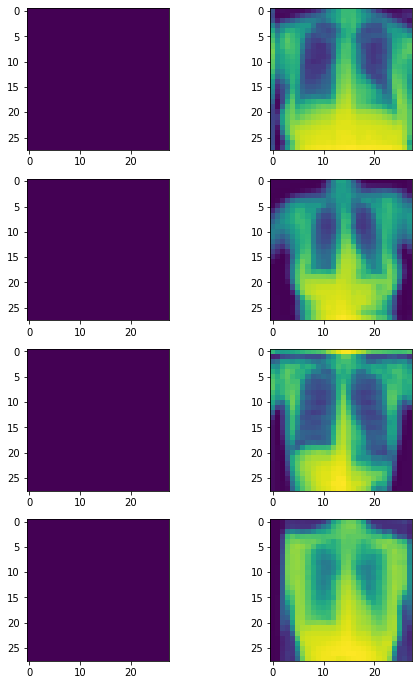

In [9]:
# Instantiate datasets
our_data = ChestMNIST(
    data_path="./chestmnist.npz",
    split="train",
    p=1,
    transform=None
)

# Plots
fig, ax = plt.subplots(4, 2, figsize=(8,12))
for i in range(4):
    ax[i][0].imshow(our_data[i][0])
    ax[i][1].imshow(our_data[i][1])


### 2.4 Modify our ``simpleFFN`` model

* Add two more hidden layers to the model

* Change the size of the output to match the size of the input

* Change the activation of the model to [``Mish``](https://arxiv.org/abs/1908.08681)

* Change the activation of last layer, what should it be?

* Instantiate the model and print a summary


In [10]:

# dimensions = [784, 200, 100, 100, 200, 784]
dimensions = [784, 150, 50, 50, 150, 784]

class neural_net(nn.Module):
    def __init__(self, dimensions):
        super(neural_net, self).__init__()
        # fully connected
        self.fc1 = nn.Linear(dimensions[0], dimensions[1], bias=False)
        self.fc2 = nn.Linear(dimensions[1], dimensions[2], bias=False)
        self.fc3 = nn.Linear(dimensions[2], dimensions[3], bias=False)
        self.fc4 = nn.Linear(dimensions[3], dimensions[4], bias=False)
        self.fc5 = nn.Linear(dimensions[4], dimensions[-1], bias=False)
        # activation functions/special
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.mish = nn.Mish()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(0.5)

    def forward(self, X):
        # INPUT LAYER
        out = self.fc1(X.flatten(start_dim=1).float())
        out = self.mish(out)
        
        # HIDDEN 1
        out = self.fc2(out)
        out = self.mish(out)
        
        # HIDDEN 2
        out = self.fc3(out)
        out = self.mish(out)

        # HIDDEN 3
        out = self.fc4(out)
        out = self.mish(out)
        
        # OUTPUT LAYER
        out = self.fc5(out)
        out = self.sigmoid(out)

        # TRANSFORMED OUTPUT LAYER 
        return out.view(X.shape)

# model = model.to(device)


In [11]:

# dimensions = [784, 200, 50, 14]

# class neural_net(nn.Module):
#     def __init__(self, dimensions):
#         super(neural_net, self).__init__()
#         # fully connected
#         self.fc1 = nn.Linear(dimensions[0], dimensions[1], bias=False)
#         self.fc2 = nn.Linear(dimensions[1], dimensions[2], bias=False)
#         self.fc3 = nn.Linear(dimensions[2], dimensions[-1], bias=False)
#         # activation functions/special
#         self.sigmoid = nn.Sigmoid()
#         self.tanh = nn.Tanh()
#         self.mish = nn.Mish()
#         self.relu = nn.ReLU()
#         self.softmax = nn.Softmax()
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, X):
#         # out = self.fc1(X.float())
#         out = self.fc1(X.flatten(start_dim=1).float())
#         out = self.mish(out)
#         out = self.fc2(out)
#         out = self.mish(out)
#         out = self.fc3(out).reshape(-1,28,28)
#         out = self.sigmoid()
#         return out

# # model = model.to(device)


### 2.5 Prepare parameters and hyperparameters for training

* Set your hyperparameters:
    - seed: 42
    - mask probability: 0.6 (this is a heavy damaged imputation problem! We are only keeping 60% of the information)
    - learning rate: 1e-2
    - weight decay = 1e-6 (applied in optimiser)
    - batch size: 128
    - number of epochs: 30


* Instantiate ``simpleFFN`` as our model with hidden sizes: 150, 50, 50, 150

* Instantiate ``Adam`` as the optimiser

* Instantiate ``MSELoss`` as a criterion

* Collect any list of transformations you think are appropriate for this problem

* Instantiate the training and validation dataset and create the dataloader for each

* Visualise an input and target batch using ``make_grid``

In [12]:
from torchvision import datasets

In [13]:
from torchvision import transforms


In [14]:
# Hyperparameters
# set_seed(42)
mask_probability = 0.7 # (this is a heavy damaged imputation problem! We are only keeping 60% of the information)
learning_rate = 1e-2
learning_rate = 1e-4
weight_decay = 1e-6 # (applied in optimiser)
number_of_epochs = 30
batch_size = 128
# Training set up: model, optimiser, criterion
model = neural_net(dimensions)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay, lr=learning_rate)   # instantiate the optimizer
criterion = nn.MSELoss()

# Transforms, Dataset and dataloader

transformations = transforms.Compose([
    transforms.ToTensor(),
    Lambda(lambda x:  x / 255.)
])


In [15]:
train_dataset = ChestMNIST(
    data_path="./chestmnist.npz",
    split="train",
    p=mask_probability,
    transform=transformations
)

val_dataset = ChestMNIST(
    data_path="./chestmnist.npz",
    split="val",
    p=mask_probability,
    transform=transformations
)

test_dataset = ChestMNIST(
    data_path="./chestmnist.npz",
    split="test",
    p=mask_probability,
    transform=transformations
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True)




In [16]:
# # Visualise a batch sample

# ax[0].imshow(train_batch[0].reshape(-1,28,28)[0])
# ax[1].imshow(train_batch[1].reshape(-1,28,28)[0])


TypeError: Invalid shape (1, 28, 28) for image data

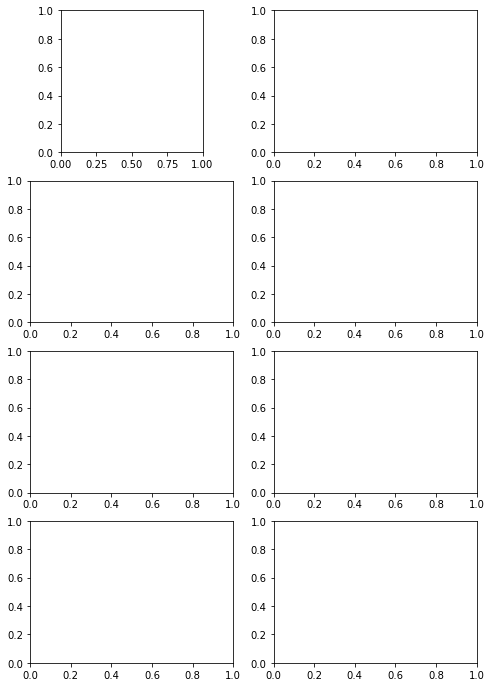

In [17]:
# Plots
train_batch = next(iter(train_loader))
# fig, ax = plt.subplots(1, 2, figsize=(8,12))
fig, ax = plt.subplots(4, 2, figsize=(8,12))
for i in range(4):
    ax[i][0].imshow(train_batch[i][0])
    ax[i][1].imshow(train_batch[i][1])

In [ ]:
#~ CHECKING EVERYTHING FITS CELL

# get a batch
train_batch = next(iter(train_loader))

# masked images
X = train_batch[0]
# unmasked images
y = train_batch[1]

# print(X.shape)
# print(y.shape)

# ensure prediction works
model = neural_net(dimensions)
output = model(X)
# print(output)

print(f"  OUTPUT SHAPE: {output.shape}")
print(f"EXPECTED SHAPE: {y.shape}")

# ensure loss works
criterion = nn.MSELoss()
print(criterion(output[0], y[0]))
print(criterion(output[1], y[0]))
print(criterion(output[1], output[1]))

# print(output[0])
# print(y[0])



### 2.6 Modify training and validation functions

* Make the necessary modifications to the ``train`` and ``valid`` functions from the lecture to adapt to our reconstruction problem

* Does prediction play a role in this problem?

* Is accuracy a suitable metric?


In [18]:
# X_float = X.float()  # Convert X to a float data type
# X_normalized = X_float / 255.0  # Normalize if X is in the range 0-255
# X_reshaped = X_normalized.reshape(-1, 28*28)  # Reshape X as per your model's input requirement
# output = model(X_reshaped)  # Now you can pass it to your model


In [22]:
# Modify functions

def train(model, optimizer, criterion, data_loader):
    model.train()
#     model = model.to(device)
    model.to(device)
    train_loss, train_accuracy = 0, 0
    for i, (input, target) in enumerate(data_loader):
        optimizer.zero_grad()
        input, target = input.to(device), target.to(device)
        output = model(input.reshape(-1,28,28))
        loss = criterion(output, target)
        loss.backward()
        train_loss += loss*input.size(0)
        optimizer.step()
#         print(f"loss = {loss}")
        if i % 100 == 0:
            print(f"{i}/{len(data_loader)}")
    train_loss = train_loss / len(data_loader.dataset)
    return train_loss


def validate(model, criterion, data_loader):
    model.eval()
#     model = model.to(device)
    model.to(device)
    valid_loss = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)
            loss = criterion(output, targets)
#             print(f"loss = {loss}")
            valid_loss += loss*inputs.size(0)

            if i % 10 == 0:
                print(f"{i}/{len(data_loader)}")
        valid_loss = valid_loss / len(data_loader.dataset)
        return valid_loss


In [23]:
# test the train and validate functions

# validate(model, 
#          criterion, 
#          val_loader)

# train(model=model,
#       optimizer=optimizer,
#       criterion=criterion,
#       data_loader=train_loader)

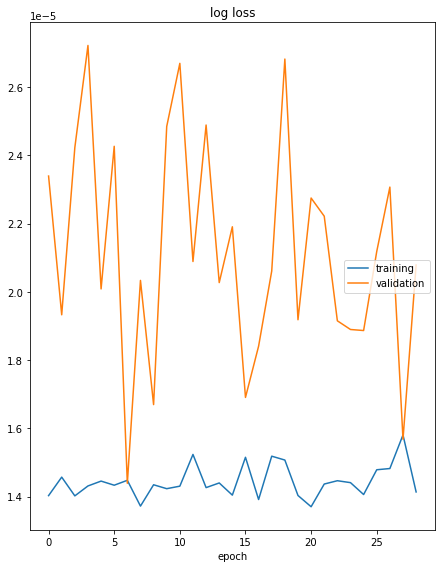

log loss
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)


In [24]:
liveloss = PlotLosses()
for epoch in range(1, 30):
   
    logs = {}
    train_loss = train(model, optimizer, criterion, train_loader)    
    validation_loss = validate(model, criterion, val_loader)
    
    logs['' + 'log loss'] = train_loss.item()
    logs['val_' + 'log loss'] = validation_loss.item()

    liveloss.update(logs)
    liveloss.draw()
#     print(validation_loss.item())


In [ ]:
:

### 2.7 Train and validate the model

* Train your model

* Visualise the output of a validation sample along training

* At the end of training, plot the 32 reconstructed and target samples from a validation batch

* What do you observe?

* Are the results as expected?


In [ ]:
:

In [ ]:
# Train model


In [ ]:
# Plot recon and target from valid batch

### 2.8 Save model to disk and load

* ``Pytorch`` stores all the parameters of models and optimizers, their weights and biases in an easy to read dictionary called a "state-dict".

* When we store models and optimizers, we store the state-dict.  

* Together with the model definition we can then restore the model to it's state when we stored it to disk.

* Let's look at the contents of the state-dict of both our optimizer and our model:

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimiser's state_dict
print("Optimiser's state_dict:")
for var_name in optimiser.state_dict():
    print(var_name, "\t", optimiser.state_dict()[var_name])


From colab (and locally) we can store models to disk using ```torch.save``` and passing both a models state_dict() and a path where to store it.

In [ ]:
#!mkdir '/content/gdrive/My Drive/models'  ## create the director for storing the model in Google Drive

model_save_name = 'chestmnist_simpleFFN_model.pt'           # .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/gdrive/My Drive/models/{model_save_name}" # use this to store in your Google Drive storage
path = F'./{model_save_name}'                               # use this to store locally (it will be erased once the colab session is over)
torch.save(model.state_dict(), path)

optimiser_save_name = 'chestmnist_simpleFFN_optimiser.pt'
path = F"/content/gdrive/My Drive/models/{optimiser_save_name}"
path = F"./{optimiser_save_name}"
torch.save(model.state_dict(), path)

Finally, we can restore models from the saved ```state_dict```'s and do a number of things such as:
1. Use it as a checkpoint and continue training (given we stored the optimizer as well)
2. Make predictions from our model
3. Perform inspections of our model
4. Use our model in ensembles
5. ...

By default a loaded model is put into ```.train()``` mode. So be careful when using networks that behave different depending on training and test time e.g. dropout regularized networks or batch-normalized networks.

In [ ]:
# model_save_name = 'chestmnist_simpleFFN_model.pt'           # .pt and .pth are common file extensions for saving models in pytorch
# path = F"/content/gdrive/My Drive/models/{model_save_name}" # use this to store in your Google Drive storage
# path = F'./{model_save_name}'

# model = simpleFFN(input_size= 1 * 28 * 28, hidden_size_1=150, hidden_size_2=50, hidden_size_3=50, hidden_size_4=150).to(device) ## creates an instance of the model
# model.load_state_dict(torch.load(path)) ## loads the parameters of the model in path. state_dict is a dictionary object that maps each layer in the model to its trainable parameters (weights and biases).
# model.eval()

# valid_loss = valid(model, mseloss, valid_loader)
# print("Avg. Valid Loss: %1.3f" % valid_loss.item())

### 2.8 Training with Unet

* Instantiate a ``U-net`` using the snipped below.

* For now you do not need to understand what a ``U-net`` is or how it works. This will be explored later in the course.

* Print the summary of the model and have a look at what kind of layers it includes. Search for these layers in the ``Pytorch`` documentation to gain a general understanding of their operations.



In [ ]:
# from monai.networks.nets import UNet
# set_seed(42)
# model = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=(8, 8, 8), strides=(1, 1,), act="mish").to(device)
# summ = summary(model, input_size=(1, 28, 28))


* Train the model with the same hyperparameters from before. Don't forget to re-initialise the optimiser with the correct model parameters

* As before, visualise some validation samples along training.

* Plot 32 reconstructed and target samples from the validation batch

* Save your final model

* What differences do you observe from training with a simple feed-forward network? Why do you think that is?

In [ ]:
# Instantiate optimiser


In [ ]:
# Train model


In [ ]:
# Plot recon and target from valid batch

#### Save model